In [5]:
# Utils packages
import ast
from datetime import datetime
from pathlib import Path, PurePath
from typing import List

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from PIL import Image, ImageFile

# Analysis packages
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Model packages
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers 

## Package flags

In [6]:
# Allow truncated images to be loaded during training
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Read dataset file

In [7]:
DATA_PATH = "data" # Directory to drop collected data.

In [8]:
hentais_df = pd.read_csv(
    Path(DATA_PATH) / "metadata.csv",
    index_col=None,
    converters={
        column_name: ast.literal_eval
        for column_name in ["tag", "group", "parody", "character", "artist", "category", "image_urls"]
    }
)
hentais_df

FileNotFoundError: [Errno 2] No such file or directory: 'data2\\metadata.csv'

## Data preparation

The following preparation steps aim to create training and validation sets that can be used for machine learning.
For example, if a hentai tag is rare, we will remove it from the target variable.
The model will not learn how to predict that genre if the data covering it is insufficient.

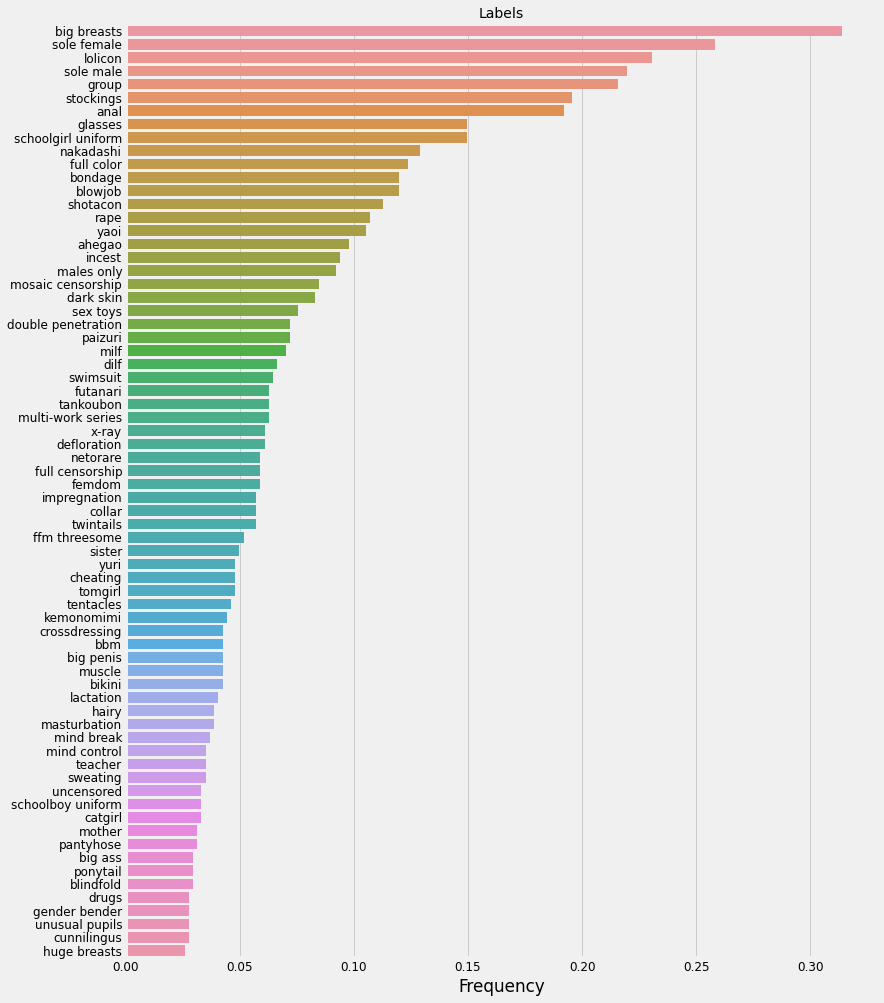

In [175]:
# Get label frequencies in descending order
label_freq = hentais_df["tag"].explode().value_counts()
label_freq = label_freq / len(hentais_df["tag"])
label_freq = label_freq.head(70)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12, 16))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Labels", fontsize=14)
plt.xlabel("Frequency")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Remove infrequent labels

We will consider as a rare label every label that is covered by less than 5% in our dataset.
We will assume that rare labels are very hard to predict due to lack of sufficient data.
The model that we will train later will not focus on predicting these labels.
So, we need to make some transformation in the label column (tag) where we ignore infrequent labels by hiding them.

In [176]:
rare_label_df = label_freq[label_freq < 0.05]
rare_label_df

sister               0.049815
yuri                 0.047970
cheating             0.047970
tomgirl              0.047970
tentacles            0.046125
kemonomimi           0.044280
crossdressing        0.042435
bbm                  0.042435
big penis            0.042435
muscle               0.042435
bikini               0.042435
lactation            0.040590
hairy                0.038745
masturbation         0.038745
mind break           0.036900
mind control         0.035055
teacher              0.035055
sweating             0.035055
uncensored           0.033210
schoolboy uniform    0.033210
catgirl              0.033210
mother               0.031365
pantyhose            0.031365
big ass              0.029520
ponytail             0.029520
blindfold            0.029520
drugs                0.027675
gender bender        0.027675
unusual pupils       0.027675
cunnilingus          0.027675
huge breasts         0.025830
Name: tag, dtype: float64

Transform Genre into a list of labels and remove the rare ones

In [177]:
hentais_df["tag"] = hentais_df["tag"].apply(lambda x: [l for l in x if l not in rare_label_df])
hentais_df

,id,title,scanlator,url,api,media_id,epos,num_favorites,tag,group,parody,character,language,artist,category,cover,thumbnail,image_urls,num_pages
0,212548,Syoku,NaN,https://nhentai.net/g/212548,https://nhentai.net/api/gallery/212548,1133892,1509103975,4452,"[big breasts, milf, nakadashi, sole female, so...",[hyoco road],[occultic nine],[ririka nishizono],"['english', 'translated']",[hyocorou],[doujinshi],https://t.nhentai.net/galleries/1133892/cover.jpg,https://t.nhentai.net/galleries/1133892/thumb.jpg,[https://i.nhentai.net/galleries/1133892/1.jpg...,33
1,57170,Drug Fumi-chan Seishun Hen Ura Manga Michi,NaN,https://nhentai.net/g/57170,https://nhentai.net/api/gallery/57170,333208,1403992737,21,"[bondage, schoolgirl uniform, tankoubon]",[],[],[],['japanese'],[shin tsuguru],[manga],https://t.nhentai.net/galleries/333208/cover.jpg,https://t.nhentai.net/galleries/333208/thumb.jpg,"[https://i.nhentai.net/galleries/333208/1.jpg,...",166
2,75495,SHIRONA HAZARD,NaN,https://nhentai.net/g/75495,https://nhentai.net/api/gallery/75495,490119,1403996013,191,[big breasts],[draw go],[pokemon],[cynthia],['japanese'],[souichi],[doujinshi],https://t.nhentai.net/galleries/490119/cover.jpg,https://t.nhentai.net/galleries/490119/thumb.jpg,"[https://i.nhentai.net/galleries/490119/1.jpg,...",23
3,229284,2205-nen no Afterglow,NaN,https://nhentai.net/g/229284,https://nhentai.net/api/gallery/229284,1206999,1522895460,101,"[eyepatch, sole male, sole female]",[frozen world],[touken ranbu],[shokudaikiri mitsutada],['japanese'],[kanaso],[doujinshi],https://t.nhentai.net/galleries/1206999/cover.jpg,https://t.nhentai.net/galleries/1206999/thumb.jpg,[https://i.nhentai.net/galleries/1206999/1.jpg...,47
4,99262,moon marguerite,NaN,https://nhentai.net/g/99262,https://nhentai.net/api/gallery/99262,635686,1404000355,138,"[stockings, paizuri, lingerie, sole female, so...",[meltdown comet],[touhou project],[patchouli knowledge],['japanese'],[yukiu con],[doujinshi],https://t.nhentai.net/galleries/635686/cover.jpg,https://t.nhentai.net/galleries/635686/thumb.jpg,"[https://i.nhentai.net/galleries/635686/1.jpg,...",26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,191631,Kobayashichi no Inu Dragon,NaN,https://nhentai.net/g/191631,https://nhentai.net/api/gallery/191631,1046505,1491184635,712,"[bestiality, big breasts, inverted nipples, mo...",[zensoku rider],[kobayashi-san-chi no maid dragon],"[kobayashi, tohru]",['japanese'],[tenzen miyabi],[doujinshi],https://t.nhentai.net/galleries/1046505/cover.jpg,https://t.nhentai.net/galleries/1046505/thumb.jpg,[https://i.nhentai.net/galleries/1046505/1.jpg...,10
538,325513,Ikumi-chan Niku Niku 2,NaN,https://nhentai.net/g/325513,https://nhentai.net/api/gallery/325513,1712669,1597933877,1387,"[sole male, big breasts, collar, dark skin, so...",[amazake hatosyo-ten],[shokugeki no soma],"[souma yukihira, ikumi mito]","['chinese', 'translated']",[yoshu ohepe],[doujinshi],https://t.nhentai.net/galleries/1712669/cover.jpg,https://t.nhentai.net/galleries/1712669/thumb.jpg,[https://i.nhentai.net/galleries/1712669/1.jpg...,30
539,150615,Usamimi Danshi Koukousei ga Masaka Mob ni Okas...,NaN,https://nhentai.net/g/150615,https://nhentai.net/api/gallery/150615,868662,1449593893,36,"[anal, bunny boy, males only, yaoi, swimsuit]",[],[free],"[haruka nanase, makoto tachibana]",['japanese'],[],[doujinshi],https://t.nhentai.net/galleries/868662/cover.jpg,https://t.nhentai.net/galleries/868662/thumb.jpg,"[https://i.nhentai.net/galleries/868662/1.jpg,...",31
540,41682,Shirley to Lucchini no Gohoushi Hon,NaN,https://nhentai.net/g/41682,https://nhentai.net/api/gallery/41682,199951,1403989884,54,"[big breasts, group, lolicon]",[atsuya kougyou],[strike witches],"[francesca lucchini, charlotte e. yeager, shir...",['japanese'],[kaisen chuui],[doujinshi],https://t.nhentai.net/galleries/199951/cover.jpg,https://t.nhentai.net/galleries/199951/thumb.jpg,"[https://i.nhentai.net/galleries/199951/1.jpg,...",25


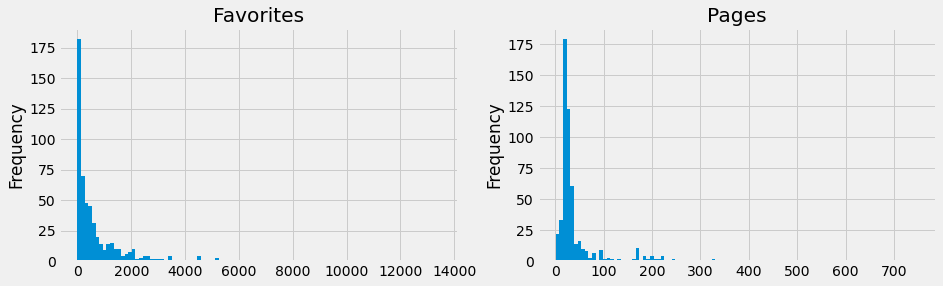

In [178]:
plt.figure(figsize=(14, 4))
hentais_df["num_favorites"].plot.hist(ax=plt.subplot(1, 2, 1), bins=100, title="Favorites")
hentais_df["num_pages"].plot.hist(ax=plt.subplot(1, 2, 2), bins=100, title="Pages")
plt.show()

In [215]:
hentais_df[hentais_df.duplicated("id")]

0        False
1         True
2         True
3         True
4         True
         ...  
25428     True
25429     True
25430     True
25431     True
25432     True
Length: 25433, dtype: bool

We need to complete the full path to locate training and test images from the current working directory.

In [179]:
def hentai_filename(hentai: pd.Series):
    return str(PurePath(DATA_PATH) / str(hentai["id"]) / Path(hentai["image_url"]).name)

hentais_df = hentais_df.explode("image_urls", ignore_index=True).rename(columns={"image_urls": "image_url"})
hentais_df = hentais_df.assign(filename=hentais_df.apply(hentai_filename, axis=1))
hentais_df

,id,title,scanlator,url,api,media_id,epos,num_favorites,tag,group,parody,character,language,artist,category,cover,thumbnail,image_url,num_pages,filename
0,212548,Syoku,NaN,https://nhentai.net/g/212548,https://nhentai.net/api/gallery/212548,1133892,1509103975,4452,"[big breasts, milf, nakadashi, sole female, so...",[hyoco road],[occultic nine],[ririka nishizono],"['english', 'translated']",[hyocorou],[doujinshi],https://t.nhentai.net/galleries/1133892/cover.jpg,https://t.nhentai.net/galleries/1133892/thumb.jpg,https://i.nhentai.net/galleries/1133892/1.jpg,33,data2\212548\1.jpg
1,212548,Syoku,NaN,https://nhentai.net/g/212548,https://nhentai.net/api/gallery/212548,1133892,1509103975,4452,"[big breasts, milf, nakadashi, sole female, so...",[hyoco road],[occultic nine],[ririka nishizono],"['english', 'translated']",[hyocorou],[doujinshi],https://t.nhentai.net/galleries/1133892/cover.jpg,https://t.nhentai.net/galleries/1133892/thumb.jpg,https://i.nhentai.net/galleries/1133892/2.jpg,33,data2\212548\2.jpg
2,212548,Syoku,NaN,https://nhentai.net/g/212548,https://nhentai.net/api/gallery/212548,1133892,1509103975,4452,"[big breasts, milf, nakadashi, sole female, so...",[hyoco road],[occultic nine],[ririka nishizono],"['english', 'translated']",[hyocorou],[doujinshi],https://t.nhentai.net/galleries/1133892/cover.jpg,https://t.nhentai.net/galleries/1133892/thumb.jpg,https://i.nhentai.net/galleries/1133892/3.jpg,33,data2\212548\3.jpg
3,212548,Syoku,NaN,https://nhentai.net/g/212548,https://nhentai.net/api/gallery/212548,1133892,1509103975,4452,"[big breasts, milf, nakadashi, sole female, so...",[hyoco road],[occultic nine],[ririka nishizono],"['english', 'translated']",[hyocorou],[doujinshi],https://t.nhentai.net/galleries/1133892/cover.jpg,https://t.nhentai.net/galleries/1133892/thumb.jpg,https://i.nhentai.net/galleries/1133892/4.jpg,33,data2\212548\4.jpg
4,212548,Syoku,NaN,https://nhentai.net/g/212548,https://nhentai.net/api/gallery/212548,1133892,1509103975,4452,"[big breasts, milf, nakadashi, sole female, so...",[hyoco road],[occultic nine],[ririka nishizono],"['english', 'translated']",[hyocorou],[doujinshi],https://t.nhentai.net/galleries/1133892/cover.jpg,https://t.nhentai.net/galleries/1133892/thumb.jpg,https://i.nhentai.net/galleries/1133892/5.jpg,33,data2\212548\5.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25428,265484,Cosplay Kanojo ga Netorareru Hon BB-chan Hen,NaN,https://nhentai.net/g/265484,https://nhentai.net/api/gallery/265484,1378265,1552153001,502,"[big breasts, cosplaying, deepthroat, netorare...",[unyarara daihanten],[fate grand order],[bb],['japanese'],[mabuchoko m],[doujinshi],https://t.nhentai.net/galleries/1378265/cover.jpg,https://t.nhentai.net/galleries/1378265/thumb.jpg,https://i.nhentai.net/galleries/1378265/22.jpg,26,data2\265484\22.jpg
25429,265484,Cosplay Kanojo ga Netorareru Hon BB-chan Hen,NaN,https://nhentai.net/g/265484,https://nhentai.net/api/gallery/265484,1378265,1552153001,502,"[big breasts, cosplaying, deepthroat, netorare...",[unyarara daihanten],[fate grand order],[bb],['japanese'],[mabuchoko m],[doujinshi],https://t.nhentai.net/galleries/1378265/cover.jpg,https://t.nhentai.net/galleries/1378265/thumb.jpg,https://i.nhentai.net/galleries/1378265/23.jpg,26,data2\265484\23.jpg
25430,265484,Cosplay Kanojo ga Netorareru Hon BB-chan Hen,NaN,https://nhentai.net/g/265484,https://nhentai.net/api/gallery/265484,1378265,1552153001,502,"[big breasts, cosplaying, deepthroat, netorare...",[unyarara daihanten],[fate grand order],[bb],['japanese'],[mabuchoko m],[doujinshi],https://t.nhentai.net/galleries/1378265/cover.jpg,https://t.nhentai.net/galleries/1378265/thumb.jpg,https://i.nhentai.net/galleries/1378265/24.jpg,26,data2\265484\24.jpg
25431,265484,Cosplay Kanojo ga Netorareru Hon BB-chan Hen,NaN,https://nhentai.net/g/265484,https://nhentai.net/api/gallery/265484,1378265,1552153001,502,"[big breasts, cosplaying, deepthroat, netorare...",[unyarara daihanten],[fate gran

## Image examples

Let's display some examples of training images.

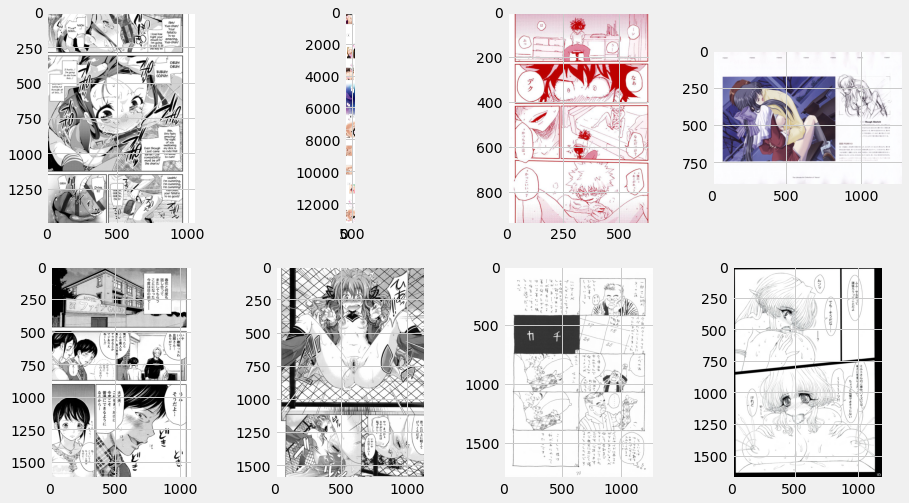

In [180]:
nobjs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobjs // ncols # Number of rows in display

plt.figure(figsize=(14, 4 * nrows))
for i, filename in enumerate(hentais_df["filename"].sample(nrows * ncols)):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.imshow(Image.open(filename).convert("RGB"))

## Train / val split

Splitting the modeling data into training and validation is common in machine learning practice.
We will be allocating 80% of the images for training and 20% for validation.
Usually, we keep a final test set to communicate performance results but we will not really need it in this notebook.

In [181]:
X, Y = hentais_df["filename"].to_numpy(), hentais_df["tag"].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=44)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=44)

print("Number of hentais for training: ", len(X_train))
print("Number of hentais for validation: ", len(X_val))
print("Number of hentais for test: ", len(X_test))

Number of hentais for training:  16276
Number of hentais for validation:  5087
Number of hentais for test:  4070


## Label encoding

The original targets are lists of strings that can be easily understood by humans.
But, if we want to build and train a neural network we need to create binary labels (multi-hot encoding).
This is critical for multi-label classification.

In order to binarize our labels, we will be using scikit-learn's MultiLabelBinarizer.

In [182]:
# Fit the multi-label binarizer on the training set
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Analyze the number of labels in the dataset for
# the output layer of our subsequent model.
labels_df = pd.Series(mlb.classes_)
labels_df

0                       3d
1           age regression
2                   ahegao
3      all the way through
4         already uploaded
              ...         
317              wolf girl
318                  x-ray
319                yandere
320                   yaoi
321                 zombie
Length: 322, dtype: object

Analyze the number of labels in the dataset for the output layer of our subsequent model.

In [183]:
nlabels = len(labels_df)

transform the targets of the training and test sets

In [184]:
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)
y_test_bin = mlb.transform(y_test)

## Input pipeline

If you are familiar with keras.preprocessing you may know the image data iterators (E.g. ImageDataGenerator, DirectoryIterator).
These iterators are convenient for multi-class classfication where the image directory contains one subdirectory for each class.
But, in the case of multi-label classification, having an image directory that respects this structure is not possible because one observation can belong to multiple classes at the same time.

That is where the tf.data API has the upper hand.
- It is faster.
- It provides fine-grained control.
- It is well integrated with the rest of TensorFlow.

We first need to write some function to parse image files and generate a tensor representing the features and a tensor representing the labels.
- In this function we can resize the image to adapt to the input expected by the model.
- We can also normalize the pixel values to be between 0 and 1. This is a common practice that helps speed up the convergence of training.

If we consider every pixel as a feature, we would like these features to have a similar range so that the gradients don't go out of control and that we only need one global learning rate multiplier.

In [185]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

In [201]:
def parse_function(filename: tf.Tensor, label: int) -> (tf.Tensor, List[int]):
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

To train a model on our dataset we want the data to be:

- Well shuffled
- Batched
- Batches to be available as soon as possible.

These features can be easily added using the tf.data.Dataset abstraction.

In [202]:
BATCH_SIZE = 256 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

AUTOTUNE will adapt the preprocessing and prefetching workload to model training and batch consumption.
The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step.
AUTOTUNE will prompt the tf.data runtime to tune the value dynamically at runtime and reduce GPU and CPU idle time.

We can now create a function that generates training and validation datasets for TensorFlow.

In [203]:
def create_dataset(filenames: List[str], labels: List[int], is_training: bool=True) -> tf.data.Dataset:
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [204]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

ValueError: in user code:

    <ipython-input-201-0a48adc89802>:7 parse_function  *
        image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    C:\Anaconda3\envs\bepeka\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    C:\Anaconda3\envs\bepeka\lib\site-packages\tensorflow\python\ops\image_ops_impl.py:1647 resize_images_v2
        skip_resize_if_same=False)
    C:\Anaconda3\envs\bepeka\lib\site-packages\tensorflow\python\ops\image_ops_impl.py:1313 _resize_images_common
        raise ValueError('\'images\' contains no shape.')

    ValueError: 'images' contains no shape.


Each batch will be a pair of arrays (one that holds the features and another one that holds the labels).
The features array will be of shape (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS).
The labels array will be of shape (BATCH_SIZE, N_LABELS) where N_LABELS is the maximum number of labels.
Let's verify the shapes of these arrays by analyzing the first batch:

In [190]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (256, 224, 224, 3)
Shape of labels array: (256, 322)


## Transfert Learning

In [191]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_url,
    input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS)
)

The feature extractor accepts images of shape (224, 224, 3) and returns a 1280-length vector for each image.

We should freeze the variables in the feature extractor layer, so that the training only modifies the new classification layers.
Usually, it is a good practice when working with datasets that are very small compared to the orginal dataset the feature extractor was trained on.

In [192]:
feature_extractor_layer.trainable = False

## Main Model

In [193]:
model = keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation="relu"),
    layers.Dense(nlabels, activation="sigmoid")
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dense_5 (Dense)              (None, 322)               330050    
Total params: 3,899,778
Trainable params: 1,641,794
Non-trainable params: 2,257,984
_________________________________________________________________


## Model training and evaluation

In [194]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 30

Compile the model to configure the training process.

In [195]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss="binary_crossentropy",
  metrics=["accuracy"]
)

Now, we pass the training dataset of (features, labels) to fit the model and indicate a seperate dataset for validation.
The performance on the validation dataset will be measured after each epoch.

In [199]:
output_dir = Path("job")
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
savedmodel_dir = output_dir / "export" / "savedmodel"
model_export_path = savedmodel_dir / timestamp
checkpoint_path = output_dir / "checkpoints"
tensorboard_path = output_dir / "tensorboard"

In [200]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(),
        keras.callbacks.EarlyStopping(patience=2),
        keras.callbacks.TensorBoard(str(tensorboard_path)),
        keras.callbacks.ModelCheckpoint(str(checkpoint_path)),
    ]
)

Epoch 1/30
 9/64 [===>..........................] - ETA: 4:07 - loss: 0.7418 - accuracy: 0.0020

InvalidArgumentError:  jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node DecodeJpeg}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_49741]

Function call stack:
train_function


In [ ]:
plt.figure(figsize=(14, 4))

ax = plt.subplot(1, 2, 1)
ax.plot(history.history["accuracy"])
ax.plot(history.history["val_accuracy"])
ax.title("model accuracy")
ax.ylabel("accuracy")
ax.xlabel("epoch")
ax.legend(["train", "validation"])

ax = plt.subplot(1, 2, 2)
ax.plot(history.history["loss"])
ax.plot(history.history["val_loss"])
ax.title("model loss")
ax.ylabel("loss")
ax.xlabel("epoch")
ax.legend(["train", "validation"])
plt.show()